# Modeling Heat Transfer on a 2D Plate Using Koopman Operator, DMD, and EDMD

In this tutorial, we will model the heat transfer on a 2D plate using the Koopman operator, Dynamic Mode Decomposition (DMD), and Extended Dynamic Mode Decomposition (EDMD). The heat conduction equation (also known as the heat equation) in two dimensions is given by:

$$
\frac{\partial u}{\partial t} = \alpha \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$

where:
- $ u = u(x, y, t) $ is the temperature field
- $( \alpha )$ is the thermal diffusivity

We will use numerical methods to simulate the heat transfer and then apply the Koopman operator, DMD, and EDMD to analyze the system.

## Step-by-Step Implementation

1. **Import Necessary Libraries**
2. **Set Up the Problem Parameters**
3. **Initialize the Temperature Field**
4. **Define Functions for Heat Transfer Simulation**
5. **Simulate Heat Transfer**
6. **Apply the Koopman Operator**
7. **Perform Dynamic Mode Decomposition (DMD)**
8. **Perform Extended Dynamic Mode Decomposition (EDMD)**
9. **Visualize the Results**

Let's get started!

## Step 1: Import Necessary Libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression

## Step 2: Set Up the Problem Parameters

We will set up the parameters for our 2D heat transfer problem.

In [2]:
# Problem parameters
Lx, Ly = 1.0, 1.0  # Length of the plate in x and y directions
Nx, Ny = 50, 50    # Number of grid points in x and y directions
dx, dy = Lx / (Nx - 1), Ly / (Ny - 1)  # Grid spacing
alpha = 0.01       # Thermal diffusivity
dt = 0.0001        # Time step
steps = 1000       # Number of time steps

# Create grid
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

## Step 3: Initialize the Temperature Field

We will initialize the temperature field with a given initial condition. For simplicity, let's start with an initial condition where the center of the plate is heated.


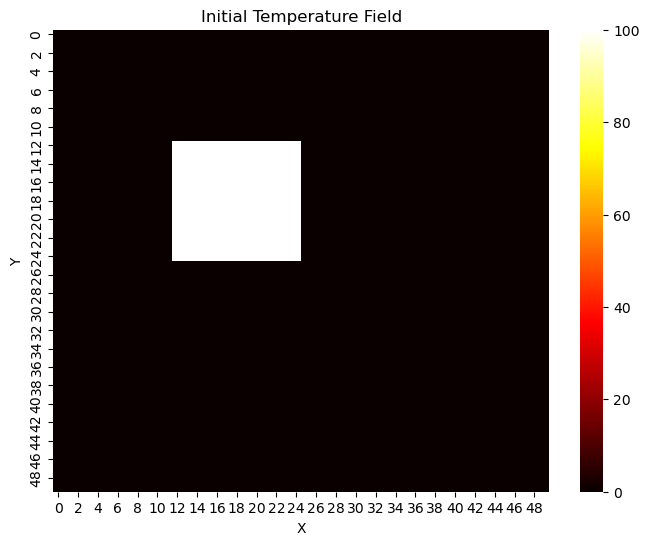

In [3]:

# Initial temperature field
u = np.zeros((Nx, Ny))
u[Nx//4:Nx//2, Ny//4:Ny//2] = 100  # Heat the center of the plate

# Plot the initial temperature field
plt.figure(figsize=(8, 6))
sns.heatmap(u, cmap='hot', cbar=True)
plt.title("Initial Temperature Field")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Step 4: Define Functions for Heat Transfer Simulation

We will define functions to simulate the heat transfer using finite differences.


In [4]:
def laplacian(u, dx, dy):
    return (np.roll(u, -1, axis=0) - 2 * u + np.roll(u, 1, axis=0)) / dx**2 + \
           (np.roll(u, -1, axis=1) - 2 * u + np.roll(u, 1, axis=1)) / dy**2

def step(u, alpha, dx, dy, dt):
    u_new = u + alpha * laplacian(u, dx, dy) * dt
    return u_new



## Step 5: Simulate Heat Transfer

We will run the simulation for the specified number of time steps and collect the data.



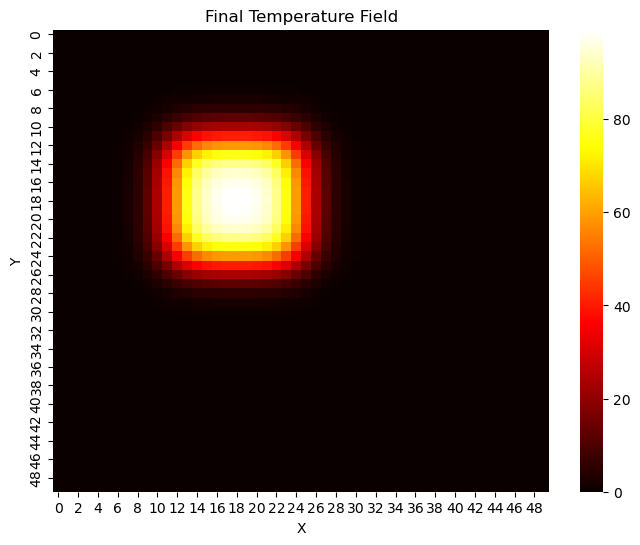

In [5]:
# Simulate heat transfer
data = []
for _ in range(steps):
    u = step(u, alpha, dx, dy, dt)
    if _ % 10 == 0:
        data.append(u.copy())

data = np.array(data)

# Plot the temperature field at the final time step
plt.figure(figsize=(8, 6))
sns.heatmap(u, cmap='hot', cbar=True)
plt.title("Final Temperature Field")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Step 6: Apply the Koopman Operator

We will apply the Koopman operator to analyze the system. For simplicity, we will use PCA to approximate the Koopman operator in this example.


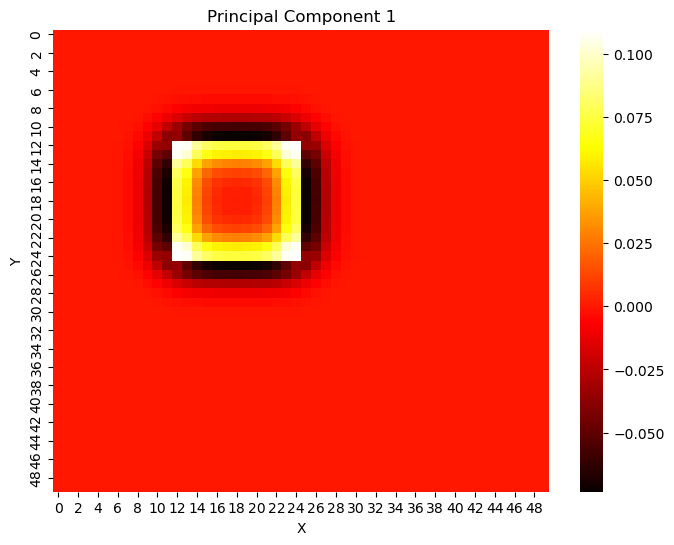

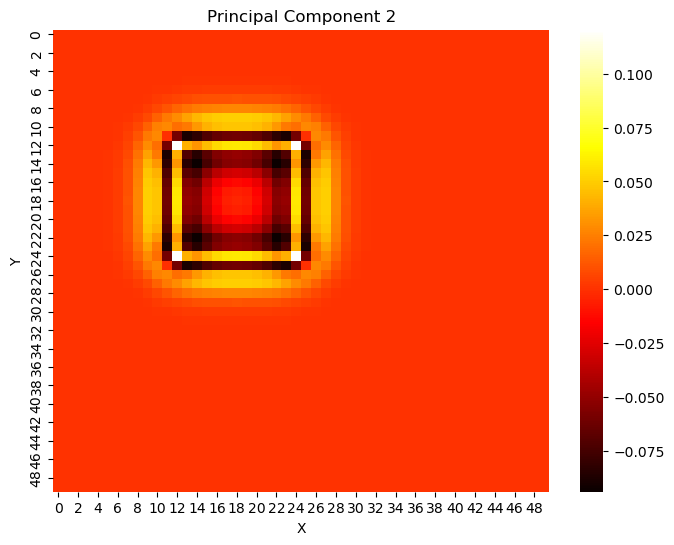

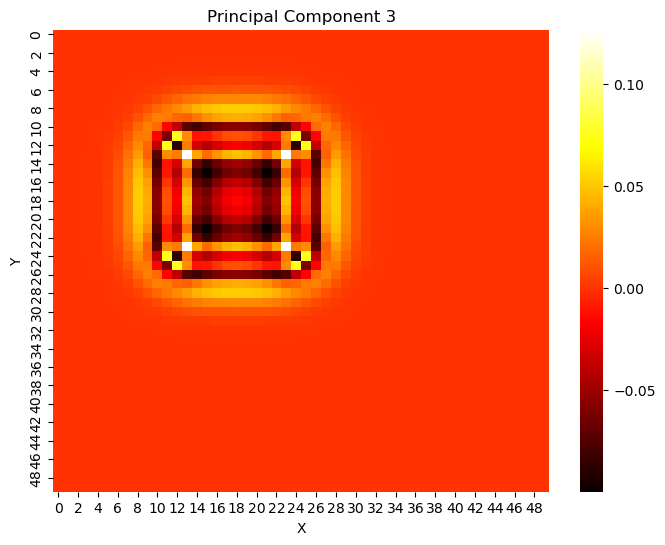

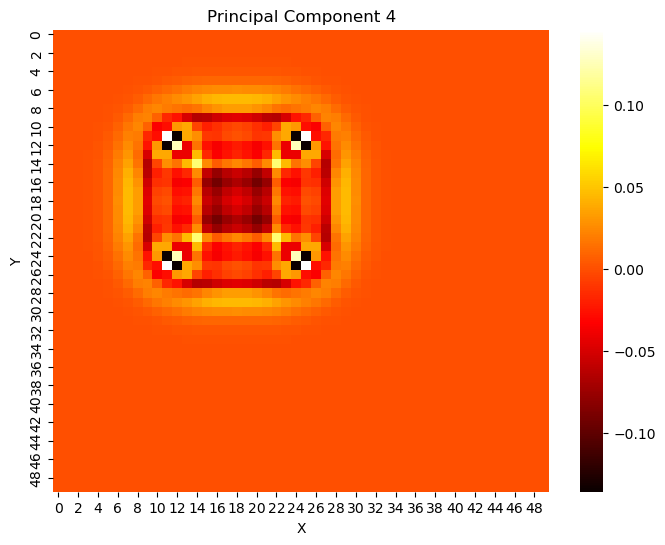

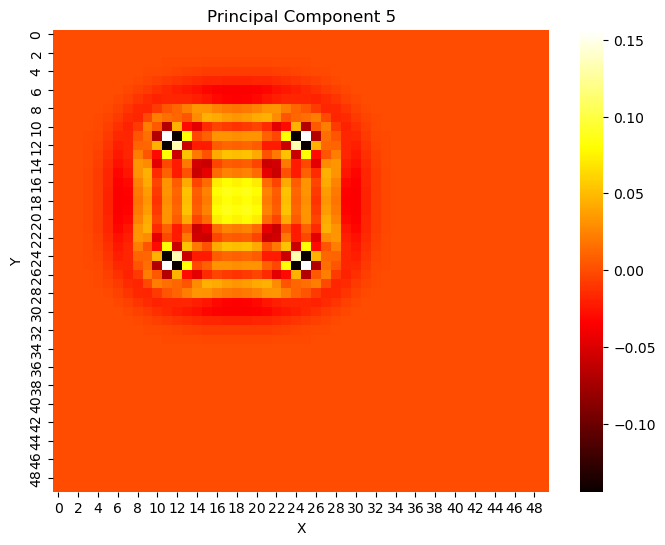

In [6]:
# Reshape data for PCA
reshaped_data = data.reshape(data.shape[0], -1)

# Apply PCA
pca = PCA(n_components=5)
pca.fit(reshaped_data)
modes = pca.components_
time_evolution = pca.transform(reshaped_data)

# Plot the principal components (modes)
for i, mode in enumerate(modes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(mode.reshape(Nx, Ny), cmap='hot', cbar=True)
    plt.title(f"Principal Component {i+1}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


## Step 7: Perform Dynamic Mode Decomposition (DMD)

We will perform DMD on the dataset to identify dominant modes [1].
Algorithm 1 (Standard DMD).
1. Arrange the data $\left\{z_0, \ldots, z_m\right\}$ into matrices

$$
X \triangleq\left[\begin{array}{lll}
z_0 & \cdots & z_{m-1}
\end{array}\right], \quad Y \triangleq\left[\begin{array}{lll}
z_1 & \cdots & z_m
\end{array}\right]
$$

2. Compute the (reduced) SVD of $X$ (see [32]), writing

$$
X=U \Sigma V^*
$$

where $U$ is $n \times r, \Sigma$ is diagonal and $r \times r, V$ is $m \times r$, and $r$ is the rank of $X$.
3. Define the matrix

$$
\tilde{A} \triangleq U^* Y V \Sigma^{-1}
$$

4. Compute eigenvalues and eigenvectors of $\tilde{A}$, writing

$$
\tilde{A} w=\lambda w
$$

5. The DMD mode corresponding to the DMD eigenvalue $\lambda$ is then given by

$$
\hat{\varphi} \triangleq U w
$$

6. If desired, the DMD modes can be scaled in a number of ways, as described in Appendix A.

[1] Tu, Jonathan H. Dynamic mode decomposition: Theory and applications. Diss. Princeton University, 2013.

1250 49


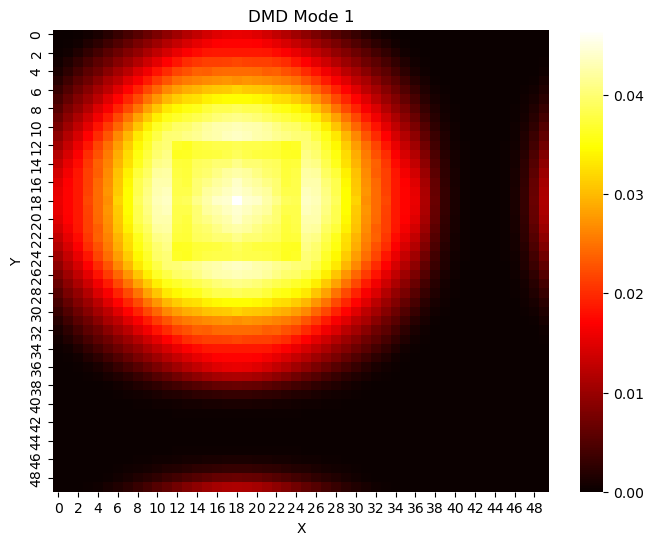

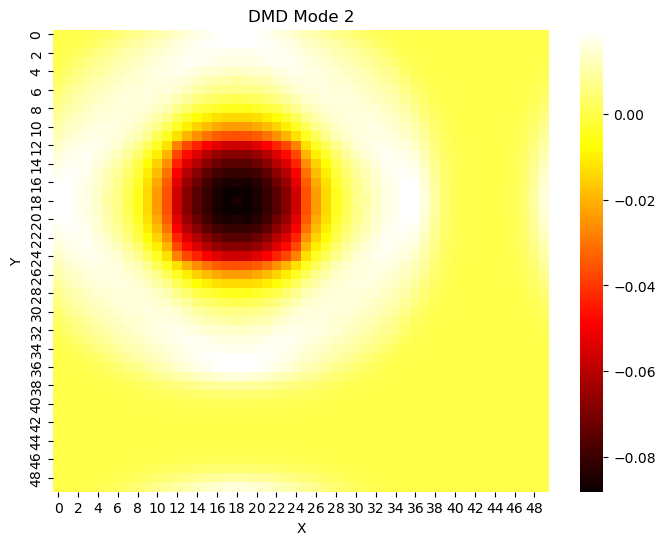

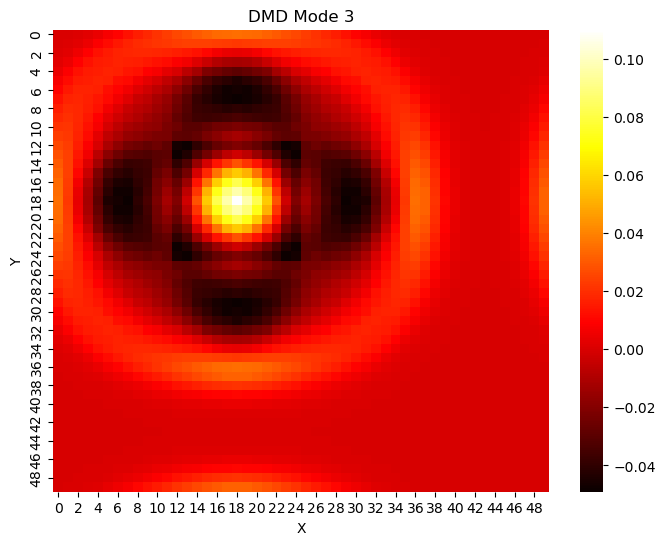

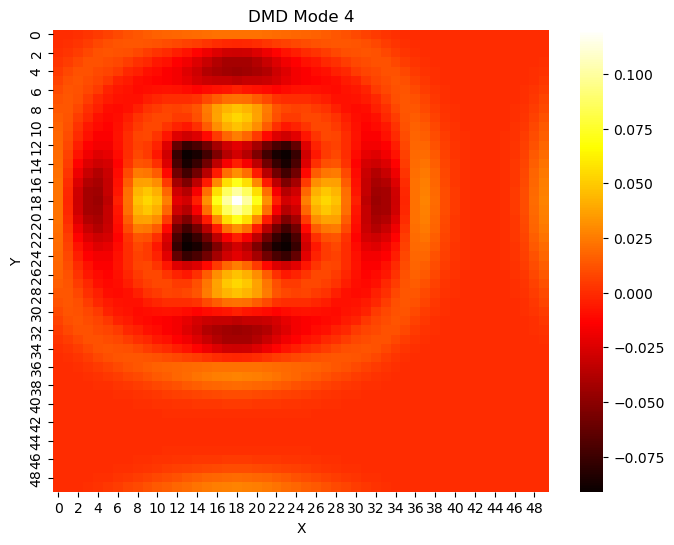

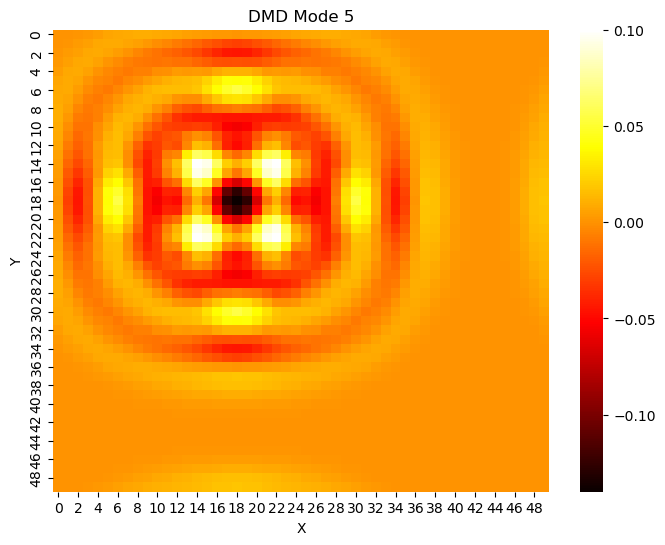

In [7]:
X1 = reshaped_data[:-1].T
X2 = reshaped_data[1:].T

U, S, Vh = np.linalg.svd(X1, full_matrices=False)
print(X1.shape[0] // 2, X1.shape[1] // 2)
r = np.min([X1.shape[0] // 2, X1.shape[1] // 2])
U = U[:, :r]
S = np.diag(S[:r])
V = Vh.T[:, :r]

Atilde = np.dot(np.dot(np.dot(U.T, X2), V), np.linalg.inv(S))
evals, evecs = np.linalg.eig(Atilde)
Phi = np.dot(np.dot(np.dot(X2, V), np.linalg.inv(S)), evecs)

# Plot DMD modes
for i in range(5):
    plt.figure(figsize=(8, 6))
    sns.heatmap(Phi[:, i].reshape(Nx, Ny).real, cmap='hot', cbar=True)
    plt.title(f"DMD Mode {i+1}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()


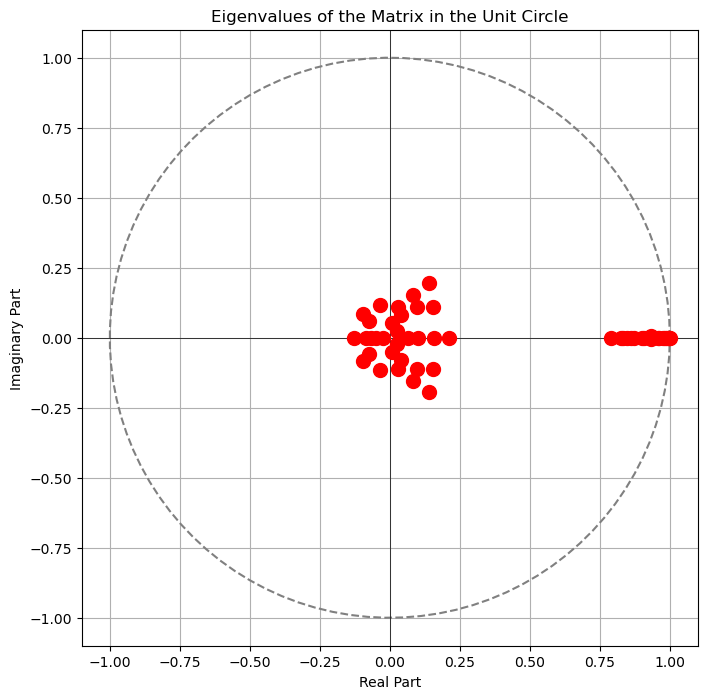

In [31]:
# Unit circle
theta = np.linspace(0, 2 * np.pi, 100)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

# Plot the eigenvalues
plt.figure(figsize=(8, 8))
plt.plot(circle_x, circle_y, linestyle='--', color='grey')  # Unit circle
plt.scatter(evals.real, evals.imag, color='red', s=100, zorder=5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title("Eigenvalues of the Koopman  in the Unit Circle")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Step 8: Perform Extended Dynamic Mode Decomposition (EDMD)

We will perform EDMD on the dataset to identify the Koopman modes.


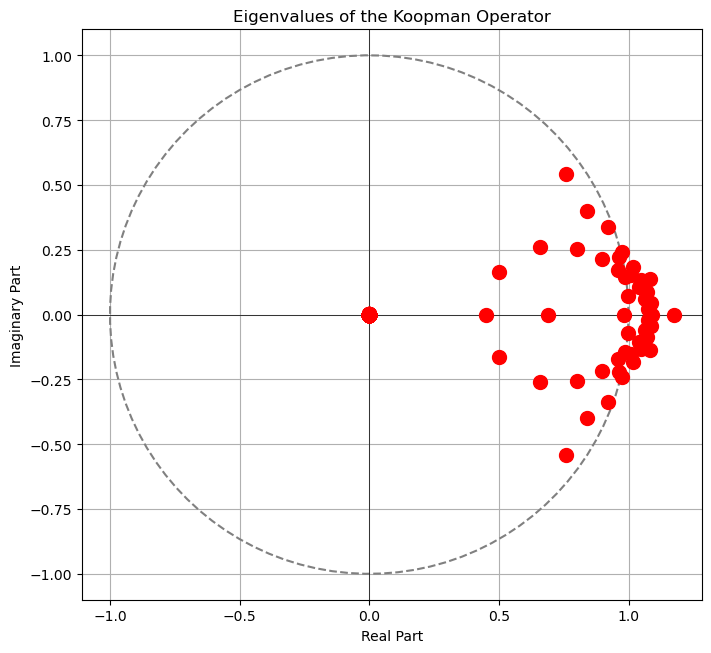

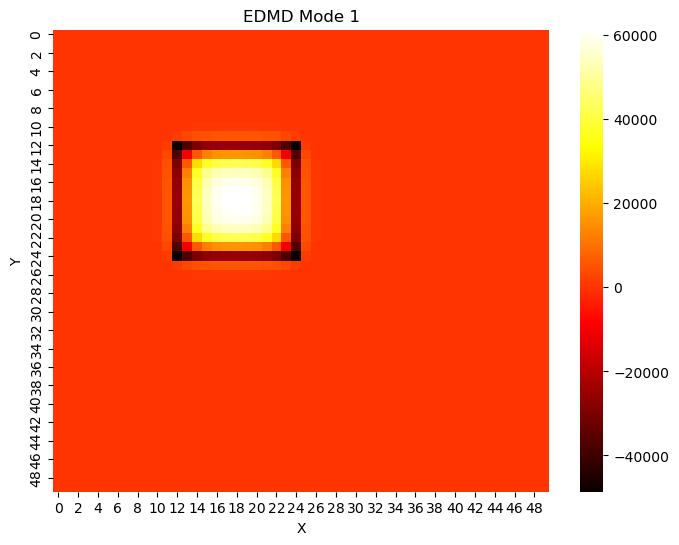

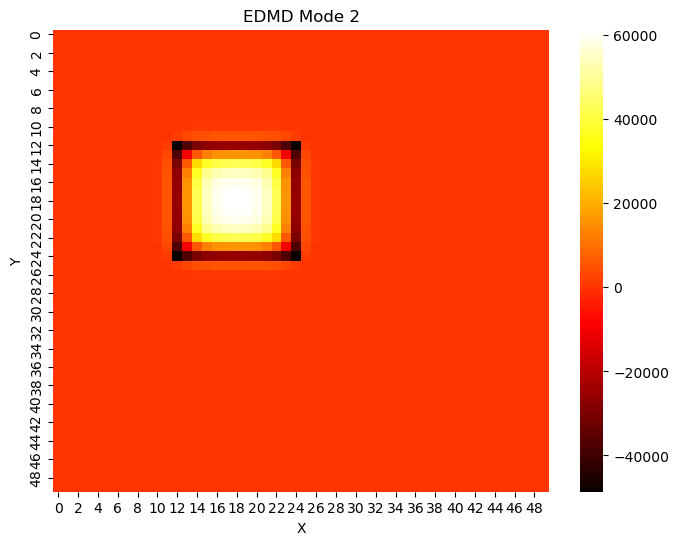

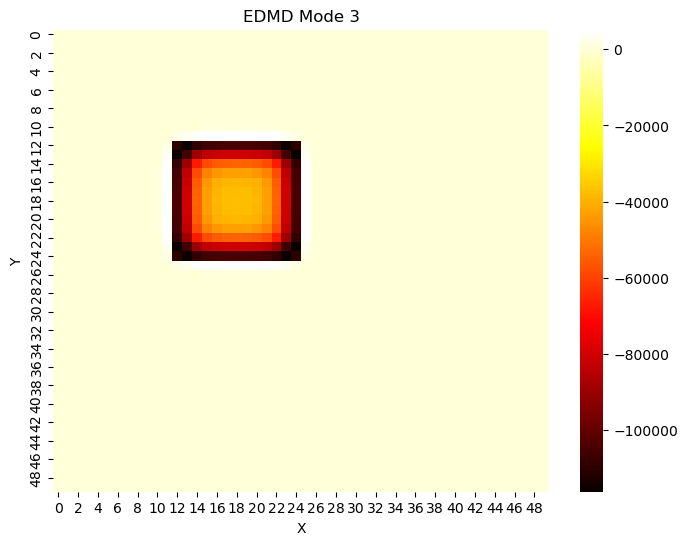

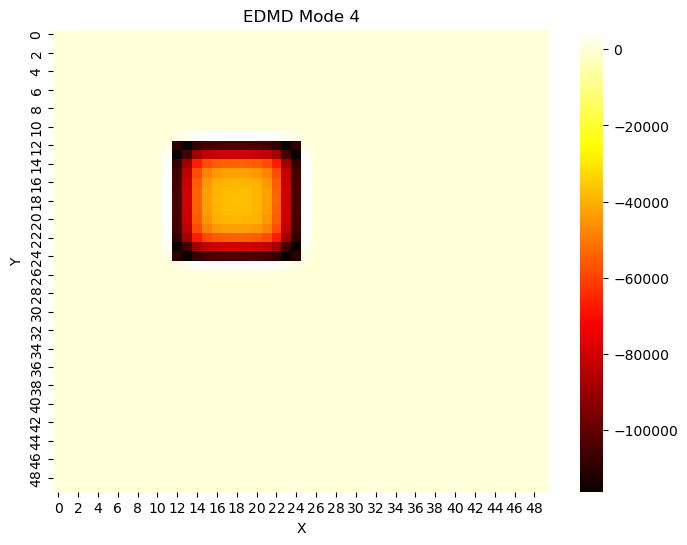

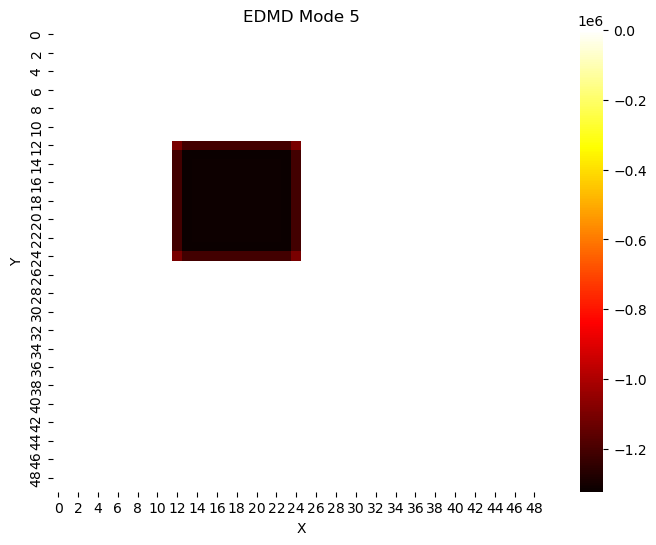

In [33]:
# Define basis functions (e.g., polynomial basis functions)
def basis_functions(x):
    return np.vstack([x, x**2, x**3]).T
    # return np.vstack([x, x**2]).T

# Apply basis functions
X1_extended = basis_functions(reshaped_data[:-1])
X2_extended = basis_functions(reshaped_data[1:])

# EDMD Algorithm
K = np.dot(X2_extended.T, np.linalg.pinv(X1_extended.T))

# Koopman modes
evals_edmd, evecs_edmd = np.linalg.eig(K)
Phi_edmd = np.dot(X2_extended, evecs_edmd)


# Unit circle
theta = np.linspace(0, 2 * np.pi, 100)
circle_x = np.cos(theta)
circle_y = np.sin(theta)

# Plot the eigenvalues
plt.figure(figsize=(8, 8))
plt.plot(circle_x, circle_y, linestyle='--', color='grey')  # Unit circle
plt.scatter(evals_edmd.real, evals_edmd.imag, color='red', s=100, zorder=5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.title("Eigenvalues of the Koopman Operator")
plt.xlabel("Real Part")
plt.ylabel("Imaginary Part")
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# print(Phi_edmd.shape)
# Plot EDMD modes
for i in range(5):
    plt.figure(figsize=(8, 6))
    sns.heatmap(Phi_edmd[:, i].reshape(Nx, Ny).real, cmap='hot', cbar=True)
    plt.title(f"EDMD Mode {i+1}")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()
